From Rxx, and Gideon, I learned about this applied SME signal boosting on quadradic funding. 

It means that the quadradic funding algorithm is weighted heavier from donors that qualify as SME.

Congrats to the TEC coordination team for pulling this off. They pulled this off on round 1.

Let's apply engineering to this process.

Engineering is about the production of artifacts in a safe and ethical way. 

Artifacts have interfaces that people may use. Engineering allows the usage of interfaces without bad things happening.



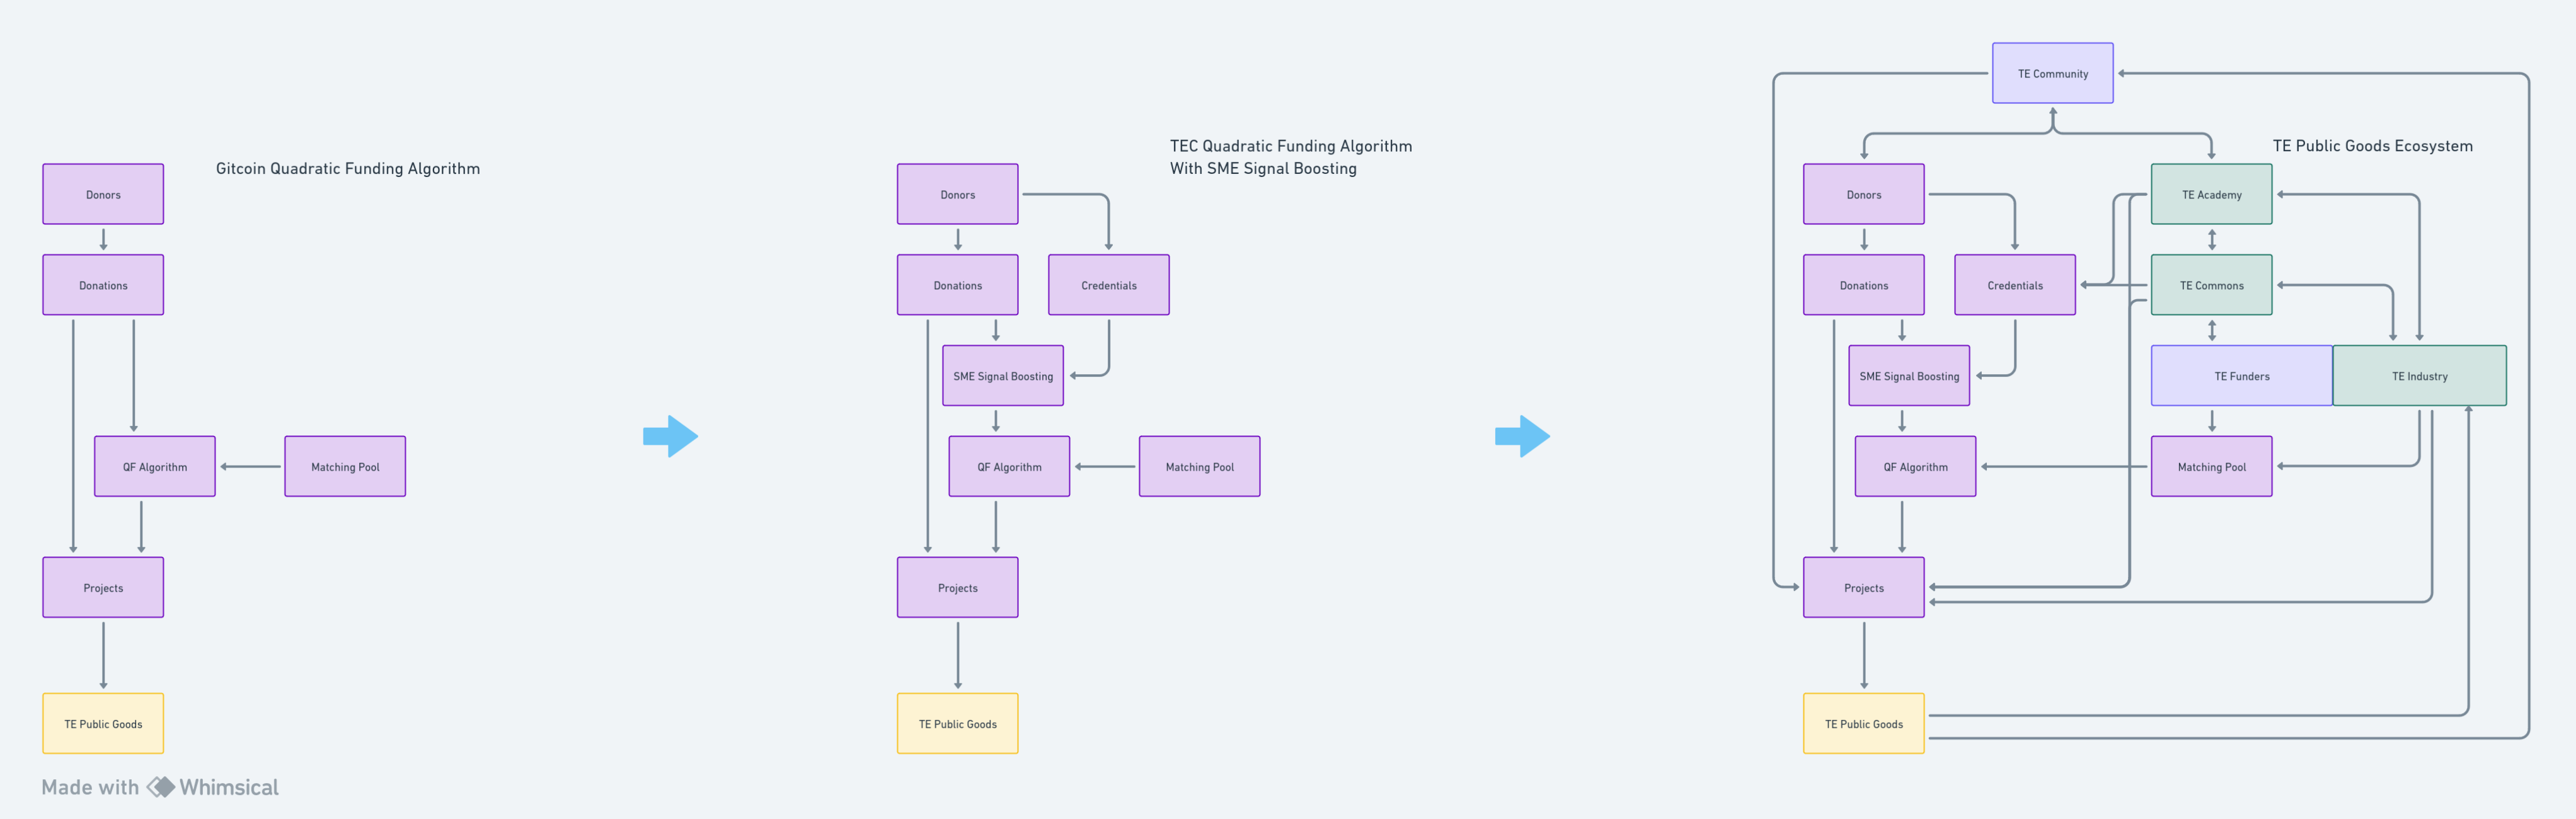![image.png]()

Link to the above board: https://whimsical.com/original-qfsme-mechanism-flowchart-QjXRdbkFmBcXBhnV175K9z 

Resources


* https://arxiv.org/pdf/2010.01193.pdf
* https://arxiv.org/pdf/1809.06421.pdf
* https://vitalik.ca/general/2019/12/07/quadratic.html
* https://qf.gitcoin.co/?grant=&grant=&grant=&match=1000
* https://medium.com/token-engineering-commons/expertise-and-quadratic-funding-bd4f0c5c3e23 

The following is a data science illustration of The foundational paper on FDFPGs. This is meant to be part one of a two part paper review, with a future modeling of Quadratic Funding and Matching Funds Requirments by Pasquini at Gitcoin. 

This worik is for educational purposes in the domain of token engineering. This work is meant to illustrate a data science approach to systems based modeling. This work is in the domain of digital signal processing, with primary foundations in machine learning, big data, data science, economics, and computing science, as those are the backgrounds of the primary authors. This work is funded by  with the Token Engineering Commons and Griff Green. 

# A Flexible Design for Funding Public Goods

Bhuterin, Hitzig, Weyl on A Flexible Design for Funding Public Goods. 

https://arxiv.org/pdf/1809.06421.pdf

The following is a data science illustration of The foundational paper on FDFPGs. This is meant to be part one of a two part paper review, with a future modeling of Quadratic Funding and Matching Funds Requirments by Pasquini at Gitcoin. 

This worik is for educational purposes in the domain of token engineering. This work is meant to illustrate a data science approach to systems based modeling. This work is in the domain of digital signal processing, with primary foundations in machine learning, big data, data science, economics, and computing science, as those are the backgrounds of the primary authors. This work is funded by  with the Token Engineering Commons and Griff Green. 

## 3.0 Model

* The Foundational Model
* Society, Citizens, Community, and Public Goods.

In [1]:
import numpy as np

# Number of Citizens in the Society
N = 100

# Max Community Size
C = 20

# Max Number of Public Goods
P = 10

# Society is a set of citizens
society = list(range(N))

# Community is a random subset of the society. The community size is from 25 up to size of the society.
community = np.random.choice(a=list(society), size=np.random.randint(1, C), replace=False, p=None)

# Public Goods are proposed by community members. Cardinality is from 20 up to size of the community.
public_goods = list(enumerate(np.random.choice(a=list(community), size=np.random.randint(1, P), replace=True, p=None)))

Community members are sampled from society.

In [2]:
community

array([12, 96, 58, 86, 45, 39, 51])

Public goods are sampled from the community with replace=True ie. a community member can steward multiple public goods.

In [3]:
public_goods

[(0, 12), (1, 12), (2, 96), (3, 96), (4, 45), (5, 39)]

In [4]:
len(society)

100

In [5]:
len(community)

7

In [6]:
len(public_goods)

6

## 3.1 Individual Preferences and Actions
* Value Function Generators
* Value Function Dataset
* Visualizing Value Functions
* Public Goods Generators
* Citizen Contribution Generators
* The Contributions Dataset
* The Utility of Citizens

### Value Function Generators

The paper calls for 
* Concave, 
* Smooth, 
* Increasing preferences towards the funding of public goods.

The following function generator, generates value functions in the domain of {[0,1],[0,1]}.

In [7]:
import param
import numpy as np
import panel as pn
import hvplot.pandas
import pandas as pd

class ConcaveFunctionGenerator(param.Parameterized):
    f0 = param.Number(default=0.2, bounds=(0, 1), doc="Value of f(0)")
    f1 = param.Number(default=0.8, bounds=(0, 1), softbounds=(0, 1), doc="Value of f(1)")
    steepness = param.Number(default=5, bounds=(1, 20), doc="Steepness of the curve")

    def __init__(self, **params):
        super().__init__(**params)
        self._update_f1_bounds()

    @param.depends('f0', watch=True)
    def _update_f1_bounds(self):
        # Clip the value of f1 if it's below f0
        self.f1 = max(self.f0, self.f1)
        
        # Update the lower bound of f1 to be the value of f0
        self.param['f1'].bounds = (self.f0, 1)
        
    def x(self):
        return np.linspace(0, 1, 400)

    @param.depends('f0', 'f1', 'steepness')
    def f(self, x):
        # Using the negative exponential function as a base
        y = 1 - np.exp(-self.steepness * x)
        
        # Adjusting the function to start at f0 and end at f1
        y = self.f0 + (self.f1 - self.f0) * (y - y.min()) / (y.max() - y.min())
        
        return y

    @param.depends('f0', 'f1', 'steepness')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01))

concave_gen = ConcaveFunctionGenerator()
pn.Row(concave_gen.param, concave_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='ConcaveFunctionGenerator'...)
        [0] StaticText(value='<b>ConcaveFunctionGenerat...)
        [1] FloatSlider(name='F0', value=0.2)
        [2] FloatSlider(name='F1', start=0.2, value=0.8)
        [3] FloatSlider(end=20, name='Steepness', start=1, value=5)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

The concave value generator has the following properties:
1. f0 = f(0) is in [0,1]
2. f1 = f(1) is in [f0,1]
3. f(x) = 1 - e**(-s*x)
4. The negative exponential function provides a smooth, concave, increasing function from f0 to f1 with a parameterized steepness.

The class dynamically clips f1 to satisfy property 2. Such as in the following example:

In [8]:
ConcaveFunctionGenerator(f0=1,f1=0)

ConcaveFunctionGenerator(f0=1, f1=1, name='ConcaveFunctionGenerator00955', steepness=5)

Here we propose parameter generators for sampling concave functions

In [9]:
import numbergen as ng
import numpy as np


# For CurveGenerator
def concave_function_parameters_generator():
    return dict(
        f0=ng.BoundedNumber(generator=ng.NormalRandom(mu=0.1, sigma=0.3), bounds=(0,1))(),
        f1=ng.BoundedNumber(generator=ng.NormalRandom(mu=0.5, sigma=0.4), bounds=(0,1))(),
        steepness=ng.UniformRandom(lbound=1, ubound=20)(),
    )

This method generates random parameters given the distributions described for f0, f1, and steepness above. 
* f0 is a normal distribution at (0.1,0.3), clipped at (0,1)
* f0 is a normal distribution at (0.5,0.4), clipped at (0,1)
* steepness is a uniform distribution at (1,20)

In [10]:
concave_function_parameters_generator()

{'f0': 0.02908484199017694,
 'f1': 0.432301123458764,
 'steepness': 5.840712882683421}

In [11]:
value_functions = [ConcaveFunctionGenerator(**concave_function_parameters_generator()) for p_i in range(len(public_goods)*len(society))]

Here we can see all of the preferences of the citizens. These are the value functions V_p_i(F_p). There is one preference function for each V_p_i in {public_goods}X{citizens}. Cardinality is len(public_goods)*len(citizens).

#### Visualizing Sampled Value Functions

In [16]:
import pandas as pd

pd.DataFrame([s.param.values() for s in value_functions])

sample_p_i_slider = pn.widgets.IntSlider(name='Utility Value Function', start=0, end=len(value_functions)-1)

pn.Row(sample_p_i_slider, pn.bind(lambda i: value_functions[i].view(), i=sample_p_i_slider))

Row
    [0] IntSlider(end=599, name='Utility Value Function')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

#### Value Functions Dataset

Create a Dataframe! These are citizen preferences by funding amounts for public goods. Take Funding Amount as the Index by applying a transpose. 

In [13]:
df_value_functions = pd.DataFrame([s.f(s.x()) for s in value_functions])
df_value_functions = df_value_functions.T
df_value_functions.shape

(400, 600)

Make Funding the Index from 0 to 100

In [14]:
df_value_functions.index = np.linspace(0,1,len(df_value_functions))
df_value_functions.index.name = "funding"

Label the Columns by {public_goods}X{Citizens}.

In [15]:
df_value_functions.columns = [(p, i) for p in public_goods for i in society]
df_value_functions.columns.name = "value_p_i"

Number of columns is len(public_goods)*len(society).

In [16]:
df_value_functions

value_p_i,"((0, 12), 0)","((0, 12), 1)","((0, 12), 2)","((0, 12), 3)","((0, 12), 4)","((0, 12), 5)","((0, 12), 6)","((0, 12), 7)","((0, 12), 8)","((0, 12), 9)",...,"((5, 39), 90)","((5, 39), 91)","((5, 39), 92)","((5, 39), 93)","((5, 39), 94)","((5, 39), 95)","((5, 39), 96)","((5, 39), 97)","((5, 39), 98)","((5, 39), 99)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,0.030068,0.140851,0.033953,0.149949,0.000000,0.124926,0.0,0.084248,0.479504,0.409225,...,0.592069,0.000000,0.257577,0.200774,0.081403,0.000000,0.159645,0.332554,0.328088,0.119241
0.002506,0.044268,0.140851,0.033953,0.153843,0.000808,0.124926,0.0,0.091482,0.479504,0.409225,...,0.592087,0.014413,0.257577,0.204480,0.082384,0.027788,0.161974,0.332554,0.345445,0.120676
0.005013,0.058116,0.140851,0.033953,0.157711,0.001584,0.124926,0.0,0.098614,0.479504,0.409225,...,0.592104,0.028460,0.257577,0.208060,0.083345,0.054340,0.164252,0.332554,0.362074,0.122060
0.007519,0.071619,0.140851,0.033953,0.161553,0.002331,0.124926,0.0,0.105646,0.479504,0.409225,...,0.592120,0.042148,0.257577,0.211518,0.084286,0.079711,0.166482,0.332554,0.378004,0.123394
0.010025,0.084788,0.140851,0.033953,0.165370,0.003050,0.124926,0.0,0.112580,0.479504,0.409225,...,0.592135,0.055488,0.257577,0.214858,0.085208,0.103954,0.168663,0.332554,0.393266,0.124679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.601864,0.140851,0.033953,0.692638,0.021129,0.124926,0.0,0.598853,0.479504,0.409225,...,0.592460,0.565851,0.257577,0.309381,0.128682,0.624960,0.267481,0.332554,0.741464,0.158959
0.992481,0.601865,0.140851,0.033953,0.692916,0.021129,0.124926,0.0,0.598881,0.479504,0.409225,...,0.592460,0.565851,0.257577,0.309381,0.128683,0.624960,0.267482,0.332554,0.741464,0.158959
0.994987,0.601866,0.140851,0.033953,0.693192,0.021129,0.124926,0.0,0.598908,0.479504,0.409225,...,0.592460,0.565852,0.257577,0.309381,0.128683,0.624960,0.267482,0.332554,0.741464,0.158959


Display Citizen Preferences for Funding.

In [17]:
# Takes rendering time.
# df_value_functions.hvplot.line(x='funding', color='blue', alpha=0.1, line_width=3, ylabel='Value to Citizens', title='Smooth, Concave, Increasing Value Functions')

Mean preferences for funding public goods.

In [18]:
df_value_functions['mean'] = df_value_functions.mean(axis=1)
df_value_functions['std'] = df_value_functions.std(axis=1)
df_value_functions['low'] = df_value_functions['mean'] - df_value_functions['std']
df_value_functions['high'] = df_value_functions['mean'] + df_value_functions['std']

df_value_functions.hvplot.line(y='mean', ylabel='Value to Society') * df_value_functions.hvplot.area(y='low',y2='high', alpha=0.5, title='Mean Value to Society Given Funding of Public Goods')

:Overlay
   .Curve.I :Curve   [funding]   (mean)
   .Area.I  :Area   [funding]   (low,high)

Remove the stats columns. 

In [19]:
df_value_functions.drop(['mean','std','low','high'],axis=1,inplace=True)

Moving on..

Each citizen i can make contributions to the funding of each public good p out of their resources c_p_i. The total utility then of citizen i is: [sum(V_p_i(F_p))  - c_p_i - t_i for all p in public_goods]

### Public Goods Funding Generators

To use V_P(F_P) to calculate value outcomes, we need an F_P which is a vector of funding amounts for public goods. We can sample F_P as a distribution of funding amounts.

#### Public Goods Pareto Distribution

Let's do a pareto distribution instead as that makes more sense for funding distributions.

In [20]:
import numpy as np

def generate_pareto(n, alpha=2):
    # Generate Pareto samples
    samples = np.random.pareto(alpha, n)
    
    # Normalize to make them sum to 1
    normalized_samples = samples / samples.sum()
    
    # Clip values to [0,1]
    clipped_samples = np.clip(normalized_samples, 0, 1)
    
    # Adjust to ensure they still sum to 1 after clipping
    clipped_samples /= clipped_samples.sum()
    
    return clipped_samples

n = len(public_goods)
pareto_samples = generate_pareto(n)


In [21]:
pd.DataFrame(pareto_samples).sort_values(0,ascending=False).reset_index(drop=True).hvplot(title='Public Goods Funding Distribution', xlabel='Public Good', ylabel='Funding')

:Curve   [index]   (0)

In [22]:
generate_public_goods_pareto_distribution = lambda n: pd.Series(generate_pareto(n), name='Public Goods Funding Distribution')
public_goods_funding_distribution = generate_public_goods_pareto_distribution(n=len(public_goods))
public_goods_funding_distribution

0    0.038883
1    0.000759
2    0.009237
3    0.122240
4    0.771139
5    0.057742
Name: Public Goods Funding Distribution, dtype: float64

### Citizen Contributions Generator

Given a citizen i, this model selects a k public goods to donate to. The number of public goods to donate to is sampled from a beta decay centered at 8 in range [1,len(public_goods)].

Once k is sampled, a normal distribution of size k is sampled, and padded with 0s to be of size n. Then all is shuffled to distribute 0s randomly.

In [23]:
import numpy as np
from icecream import ic
ic.configureOutput(prefix='ic|',outputFunction=print)

n = len(public_goods)
ic(n)
k = int(np.clip(np.random.exponential(8), 1, n))
ic(k)
distribution = np.pad(np.abs(np.random.normal(size=k)), (0, n-k))
np.random.shuffle(distribution)
distribution /= distribution.sum()

ic|n: 6
ic|k: 3


In [24]:
import param
import panel as pn
import hvplot.pandas
import pandas as pd
import numpy as np
from icecream import ic

ic.configureOutput(prefix='ic|', outputFunction=print)

class CustomDistributionGenerator(param.Parameterized):
    n = param.Integer(default=100, bounds=(1, 1000), constant=True)
    mean_exponential = param.Integer(default=4, bounds=(1, 50))
    data = param.Array(precedence=-1)
    
    def __init__(self, **params):
        super().__init__(**params)
        self.generate_distribution()
    
    def f(self):
        k = int(np.clip(np.random.exponential(self.mean_exponential), 1, self.n))
        distribution = np.pad(np.abs(np.random.normal(size=k)), (0, self.n-k))
        np.random.shuffle(distribution)
        distribution /= distribution.sum()
        return distribution
    
    def x(self):
        return np.arange(self.n)
    
    @param.depends('n', 'mean_exponential', watch=True)
    def generate_distribution(self):
        self.data = self.f()
    
    @param.depends('data')
    def view(self):
        df = pd.DataFrame({'Value': self.data})
        return df.hvplot.step('index', 'Value', xlim=(0, self.n), ylim=(0, 1.01), title='Sample Public Goods Funding Amounts by citizen I')

# Create an instance
dist_gen = CustomDistributionGenerator(n=len(public_goods))

# Use panel to render the interactive system
pn.Row(dist_gen.param, dist_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='CustomDistributionGenerat...)
        [0] StaticText(value='<b>CustomDistributionGene...)
        [1] IntSlider(disabled=True, end=1000, name='N', start=1, value=6)
        [2] IntSlider(end=50, name='Mean exponential', start=1, value=4)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

### The Contributions Dataset

The above can be used to sample a contributions vector for each citizen to generate the contributions matrix. The matrix should be {society}X{public_good}

In [25]:
len(public_goods)

6

In [26]:
len(society)

100

Generate public goods funding contributions for each citizen in the society.

In [27]:
contributions = pd.DataFrame([CustomDistributionGenerator(n=len(public_goods)).data for i in society])

contributions.columns.name = 'Public Good'
contributions.index.name = 'Citizen'

contributions

Public Good,0,1,2,3,4,5
Citizen,,,,,,
0,0.000000,0.329391,0.229766,0.000000,0.000000,0.440843
1,0.149740,0.100864,0.158056,0.245015,0.031468,0.314857
2,0.819494,0.000000,0.000000,0.056814,0.123692,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
96,0.141274,0.155042,0.082972,0.039766,0.175225,0.405721
97,0.324838,0.151477,0.290033,0.188037,0.045615,0.000000


In [28]:
contributions.sum()

Public Good
0    18.485021
1    15.576878
2    16.571480
3    15.778282
4    12.847851
5    20.740488
dtype: float64

In [29]:
contributions.sum(axis=1)

Citizen
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
95    1.0
96    1.0
97    1.0
98    1.0
99    1.0
Length: 100, dtype: float64

In [30]:
contributions.sum().sum()

99.99999999999999

Public Goods Funded Per Citizen. In other words, signal preference per citizen.

In [31]:
h1 = contributions.hvplot.heatmap(title="Signal Preference Per Citizen", cmap='Blues', fontscale=1.2, width=800, height=800, xlabel='Public Good', ylabel='Citizen', clabel='Amount Contributed from citizen i to public_good p.').opts(default_tools=[])
h1

:HeatMap   [columns,index]   (value)

Citizen Cost Distribution per Public Good. In other words, cost distribution per public good.

In [32]:
public_goods_funding = (contributions / contributions.sum(axis=0))

In [33]:
public_goods_funding.sum(axis=0)

Public Good
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
dtype: float64

In [34]:
public_goods_funding.sum(axis=1)

Citizen
0     0.056266
1     0.057272
2     0.057561
3     0.048215
4     0.060345
        ...   
95    0.077834
96    0.058323
97    0.060267
98    0.063724
99    0.054098
Length: 100, dtype: float64

In [35]:
public_goods_funding.sum().sum()

6.0

In [36]:
h2 = public_goods_funding.hvplot.heatmap(title='Cost Distribution per Public Good', cmap='Reds', fontscale=1.2, width=800, height=800, xlabel='Public Good', ylabel='Citizen', clabel='Amount Contributed from citizen i to public_good p.').opts(default_tools=[])
h2

:HeatMap   [columns,index]   (value)

In [37]:
h1 + h2

:Layout
   .HeatMap.I  :HeatMap   [columns,index]   (value)
   .HeatMap.II :HeatMap   [columns,index]   (value)

### Normalized Contributions

In [38]:
# Normalize relative to our public_goods funding distribution.
normalized_contributions = contributions * public_goods_funding_distribution / contributions.sum()

In [39]:
h3 = normalized_contributions.hvplot.heatmap(title="Normalized Contributions", cmap='Purples', fontscale=1.2, width=800, height=800, xlabel='Public Good', ylabel='Citizen', clabel='Amount Contributed from citizen i to public_good p.').opts(default_tools=[])
h3

:HeatMap   [columns,index]   (value)

#### The Normalized (Original) Public Goods Distribution

In [40]:
normalized_contributions.sum(axis=0)

Public Good
0    0.038883
1    0.000759
2    0.009237
3    0.122240
4    0.771139
5    0.057742
dtype: float64

#### The Normalized Citizen Cost Distribution

In [41]:
normalized_contributions.sum(axis=1)

Citizen
0     0.001371
1     0.005072
2     0.009588
3     0.002784
4     0.000557
        ...   
95    0.060021
96    0.012306
97    0.005047
98    0.004503
99    0.002103
Length: 100, dtype: float64

In [42]:
normalized_contributions.sum().sum()

0.9999999999999998

### The Total Utility of Citizens

#### Value Functions Dataset Revisited

Melting preferences to get groupby on public good or on citizen.

In [43]:
df_value_functions_melted = df_value_functions.melt(ignore_index=False)
df_value_functions_melted['public_good'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[0]).astype(str)
df_value_functions_melted['citizen'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[1]).astype(str)
df_value_functions_melted

,value_p_i,value,public_good,citizen
funding,,,,
0.000000,"((0, 12), 0)",0.030068,"(0, 12)",0
0.002506,"((0, 12), 0)",0.044268,"(0, 12)",0
0.005013,"((0, 12), 0)",0.058116,"(0, 12)",0
0.007519,"((0, 12), 0)",0.071619,"(0, 12)",0
0.010025,"((0, 12), 0)",0.084788,"(0, 12)",0
...,...,...,...,...
0.989975,"((5, 39), 99)",0.158959,"(5, 39)",99
0.992481,"((5, 39), 99)",0.158959,"(5, 39)",99
0.994987,"((5, 39), 99)",0.158959,"(5, 39)",99


Groupby funding and public good to get mean funding preferences per public good.

Display mean value function per public good.

In [44]:
df_value_functions_melted.groupby(['funding', 'public_good'])[['value']].mean().reset_index().hvplot.line(y='value', by='public_good', alpha=0.8, line_width=4, x='funding', title='Mean Value to Society per Public Good Given Funding')

:NdOverlay   [public_good]
   :Curve   [funding]   (value)

Display mean value function per citizen.

In [45]:
df_value_functions_melted.groupby(['funding', 'citizen'])[['value']].mean().reset_index().hvplot.line(y='value', by='citizen', alpha=0.8, line_width=4, x='funding', title='Mean Value per Citizen as Public Goods are Funded')

:NdOverlay   [citizen]
   :Curve   [funding]   (value)

Total value per public good given funding.

In [46]:
df_value_functions_melted.pivot_table(index='funding', columns='public_good', values='value', aggfunc='sum')

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,18.530765,18.147440,19.164828,16.601862,18.508165,16.490946
0.002506,19.322833,19.103105,20.107507,17.790803,19.660652,17.357415
0.005013,20.090702,20.027926,21.019761,18.941328,20.773110,18.196791
0.007519,20.835192,20.923043,21.902701,20.054841,21.847061,19.010033
0.010025,21.557093,21.789551,22.757396,21.132691,22.883965,19.798064
...,...,...,...,...,...,...
0.989975,48.930943,57.630636,55.839644,62.254432,57.893339,49.741002
0.992481,48.932377,57.638240,55.842913,62.258168,57.895486,49.742675
0.994987,48.933799,57.645805,55.846158,62.261878,57.897617,49.744334


Total value per citizen per funding of public goods.

In [47]:
df_value_functions_melted.pivot_table(index='funding', columns='citizen', values='value', aggfunc='sum')

citizen,0,1,10,11,12,13,14,15,16,17,...,90,91,92,93,94,95,96,97,98,99
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,0.463877,0.621132,0.603486,2.170564,0.418547,1.755600,0.980840,0.871215,1.387686,1.448653,...,1.861083,1.230881,0.506647,1.052799,1.545823,0.877271,1.170265,1.429490,1.402484,2.240589
0.002506,0.560022,0.703516,0.666843,2.198387,0.477719,1.807170,1.119855,0.909883,1.428126,1.531096,...,1.931130,1.260793,0.567936,1.089934,1.553123,0.951484,1.232530,1.484536,1.498105,2.251806
0.005013,0.653005,0.782737,0.727949,2.225516,0.535307,1.856928,1.253141,0.947482,1.467668,1.610641,...,1.998655,1.290157,0.627056,1.125474,1.560301,1.023138,1.292647,1.538168,1.590905,2.262662
0.007519,0.742941,0.858921,0.786890,2.251970,0.591357,1.904946,1.380939,0.984050,1.506336,1.687399,...,2.063764,1.318983,0.684092,1.159489,1.567361,1.092329,1.350694,1.590429,1.680975,2.273169
0.010025,0.829945,0.932188,0.843746,2.277771,0.645913,1.951292,1.503485,1.019620,1.544155,1.761473,...,2.126563,1.347282,0.739124,1.192046,1.574304,1.159150,1.406747,1.641357,1.768404,2.283339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,3.975752,2.994749,2.694320,3.596418,2.853625,3.423072,4.509148,3.098663,3.956173,4.248286,...,4.820249,3.107580,2.584196,1.951648,2.166609,3.308157,3.282129,3.959510,5.049931,2.644634
0.992481,3.975853,2.994790,2.694474,3.596511,2.853702,3.423076,4.509149,3.099625,3.956870,4.248634,...,4.820903,3.107731,2.584266,1.951649,2.166966,3.308167,3.282205,3.959622,5.049963,2.644700
0.994987,3.975952,2.994831,2.694628,3.596603,2.853779,3.423080,4.509150,3.100583,3.957564,4.248981,...,4.821553,3.107880,2.584336,1.951649,2.167321,3.308177,3.282280,3.959733,5.049994,2.644765


#### The Value Tensor

In [48]:
df_value_tensor = df_value_functions_melted.pivot_table(index='funding', columns=['citizen','public_good'], values='value')
df_value_tensor

citizen             0                                                    \
public_good   (0, 12)   (1, 12)   (2, 96)   (3, 96)   (4, 45)   (5, 39)   
funding                                                                   
0.000000     0.030068  0.000000  0.000000  0.000000  0.200222  0.233586   
0.002506     0.044268  0.015812  0.007243  0.010878  0.222984  0.258838   
0.005013     0.058116  0.031260  0.014276  0.021627  0.244759  0.282968   
0.007519     0.071619  0.046351  0.021105  0.032249  0.265591  0.306026   
0.010025     0.084788  0.061095  0.027737  0.042745  0.285520  0.328060   
...               ...       ...       ...       ...       ...       ...   
0.989975     0.601864  0.686234  0.250271  0.909563  0.725673  0.802147   
0.992481     0.601865  0.686235  0.250271  0.909661  0.725673  0.802147   
0.994987     0.601866  0.686237  0.250271  0.909757  0.725673  0.802147   
0.997494     0.601866  0.686238  0.250271  0.909853  0.725673  0.802147   
1.000000     0.601867  0.686240  0.250271  0.909948  0.725673  0.802147   

citizen             1                                ...        98            \
public_good   (0, 12)   (1, 12)   (2, 96)   (3, 96)  ...   (2, 96)   (3, 96)   
funding                                              ...                       
0.000000     0.140851  0.353756  0.000000  0.126525  ...  0.000000  0.354208   
0.002506     0.140851  0.354439  0.005691  0.160591  ...  0.015627  0.377209   
0.005013     0.140851  0.355113  0.011308  0.193328  ...  0.031007  0.399391   
0.007519     0.140851  0.355777  0.016853  0.224789  ...  0.046144  0.420782   
0.010025     0.140851  0.356432  0.022327  0.255023  ...  0.061041  0.441412   
...               ...       ...       ...       ...  ...       ...       ...   
0.989975     0.140851  0.402988  0.439832  1.000000  ...  0.985459  1.000000   
0.992481     0.140851  0.402991  0.439866  1.000000  ...  0.985487  1.000000   
0.994987     0.140851  0.402994  0.439900  1.000000  ...  0.985516  1.000000   
0.997494     0.140851  0.402997  0.439933  1.000000  ...  0.985543  1.000000   
1.000000     0.140851  0.402999  0.439966  1.000000  ...  0.985571  1.000000   

citizen                                99                                \
public_good   (4, 45)   (5, 39)   (0, 12)   (1, 12)   (2, 96)   (3, 96)   
funding                                                                   
0.000000     0.478005  0.328088  0.226950  0.809718  0.000000  0.314271   
0.002506     0.483152  0.345445  0.234174  0.809718  0.000479  0.316350   
0.005013     0.488075  0.362074  0.241159  0.809718  0.000955  0.318361   
0.007519     0.492783  0.378004  0.247913  0.809718  0.001429  0.320306   
0.010025     0.497287  0.393266  0.254444  0.809718  0.001900  0.322188   
...               ...       ...       ...       ...       ...       ...   
0.989975     0.596334  0.741464  0.445600  0.809718  0.082149  0.377799   
0.992481     0.596334  0.741464  0.445600  0.809718  0.082214  0.377799   
0.994987     0.596334  0.741464  0.445600  0.809718  0.082279  0.377799   
0.997494     0.596334  0.741464  0.445600  0.809718  0.082343  0.377799   
1.000000     0.596334  0.741464  0.445600  0.809718  0.082408  0.377799   

citizen                          
public_good   (4, 45)   (5, 39)  
funding                          
0.000000     0.770409  0.119241  
0.002506     0.770409  0.120676  
0.005013     0.770409  0.122060  
0.007519     0.770409  0.123394  
0.010025     0.770409  0.124679  
...               ...       ...  
0.989975     0.770409  0.158959  
0.992481     0.770409  0.158959  
0.994987     0.770409  0.158959  
0.997494     0.770409  0.158959  
1.000000     0.770409  0.158959  

[400 rows x 600 columns]

#### The Value Outcomes Tensor

Sampling by public goods funding distribution.

In [49]:
index_obj = pd.Index(df_value_tensor.index)
nearest_indices = index_obj.get_indexer(public_goods_funding_distribution, method='nearest')
df_value_outcomes_tensor = df_value_tensor.iloc[nearest_indices]
df_value_outcomes_tensor

citizen             0                                                    \
public_good   (0, 12)   (1, 12)   (2, 96)   (3, 96)   (4, 45)   (5, 39)   
funding                                                                   
0.040100     0.219485  0.213642  0.093828  0.159401  0.466960  0.527294   
0.000000     0.030068  0.000000  0.000000  0.000000  0.200222  0.233586   
0.010025     0.084788  0.061095  0.027737  0.042745  0.285520  0.328060   
0.122807     0.435117  0.467278  0.190912  0.406098  0.665672  0.740768   
0.771930     0.601645  0.685780  0.250244  0.894500  0.725672  0.802147   
0.057644     0.281207  0.284800  0.122897  0.220129  0.535918  0.602164   

citizen             1                                ...        98            \
public_good   (0, 12)   (1, 12)   (2, 96)   (3, 96)  ...   (2, 96)   (3, 96)   
funding                                              ...                       
0.040100     0.140851  0.363621  0.082773  0.537811  ...  0.222439  0.638515   
0.000000     0.140851  0.353756  0.000000  0.126525  ...  0.000000  0.354208   
0.010025     0.140851  0.356432  0.022327  0.255023  ...  0.061041  0.441412   
0.122807     0.140851  0.378188  0.207821  0.875640  ...  0.535523  0.890772   
0.771930     0.140851  0.402510  0.434282  0.999996  ...  0.980020  0.999991   
0.057644     0.140851  0.367293  0.113932  0.650151  ...  0.303264  0.719561   

citizen                                99                                \
public_good   (4, 45)   (5, 39)   (0, 12)   (1, 12)   (2, 96)   (3, 96)   
funding                                                                   
0.040100     0.538245  0.533365  0.317868  0.809718  0.007376  0.340495   
0.000000     0.478005  0.328088  0.226950  0.809718  0.000000  0.314271   
0.010025     0.497287  0.393266  0.254444  0.809718  0.001900  0.322188   
0.122807     0.582944  0.690940  0.403449  0.809718  0.020831  0.365357   
0.771930     0.596334  0.741463  0.445593  0.809718  0.075004  0.377797   
0.057644     0.553784  0.587343  0.344637  0.809718  0.010420  0.348246   

citizen                          
public_good   (4, 45)   (5, 39)  
funding                          
0.040100     0.770409  0.136921  
0.000000     0.770409  0.119241  
0.010025     0.770409  0.124679  
0.122807     0.770409  0.152420  
0.771930     0.770409  0.158959  
0.057644     0.770409  0.141928  

[6 rows x 600 columns]

#### Value Outcomes Tensor Values

In [50]:
values = df_value_outcomes_tensor.unstack().values.reshape(len(df_value_outcomes_tensor), len(df_value_outcomes_tensor.columns.levels[0]), len(df_value_outcomes_tensor.columns.levels[1]))

In [51]:
values.shape

(6, 100, 6)

#### Extract the Diagonal Plane of The Value Tensor

In [52]:
# Extract the diagonal plane
diagonal_plane = values[np.arange(values.shape[0]), :, np.arange(values.shape[2])]
diagonal_plane.shape

(6, 100)

####  The Value Outcomes Matrix V_P(F_P)

In [53]:
value_given_funding = pd.DataFrame(diagonal_plane, index=public_goods, columns=society)
value_given_funding.index.name = "public_goods"
value_given_funding.columns.name = "citizens"
value_given_funding

citizens,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
public_goods,,,,,,,,,,,,,,,,,,,,,
"(0, 12)",0.219485,0.213642,0.093828,0.159401,0.466960,0.527294,0.140851,0.363621,0.082773,0.537811,...,0.204919,0.392562,0.231978,0.422165,0.012516,0.230167,0.402459,0.178796,0.000000,0.462390
"(1, 12)",0.247031,0.085697,0.424994,0.099233,0.000000,0.000000,0.000000,0.445967,0.000000,0.412202,...,0.499280,0.000000,0.593214,0.003279,0.000000,0.000000,0.442890,0.000000,0.000000,0.294460
"(2, 96)",0.599194,0.198170,0.267346,0.038278,0.003050,0.570006,0.198306,0.333385,0.072775,0.009300,...,0.525551,0.380428,0.541363,0.250714,0.386800,0.064242,0.112542,0.399118,0.155506,0.121098
"(3, 96)",0.034660,0.187196,0.554965,0.552933,0.526932,0.521785,0.000000,0.698561,0.105835,0.785778,...,0.324027,0.886520,0.930296,0.533494,0.132509,0.342051,0.030033,0.152154,0.651592,0.526886
"(4, 45)",0.585695,0.000000,0.594109,0.444177,0.256280,0.590790,0.962696,0.726260,0.818248,0.306662,...,0.076034,0.200622,0.896407,0.424462,0.430943,0.579260,0.055842,0.211828,0.293502,0.996899
"(5, 39)",0.399510,0.255544,0.000000,0.000000,0.276010,0.630994,0.296212,0.615114,0.293887,0.224945,...,0.303264,0.719561,0.553784,0.587343,0.344637,0.809718,0.010420,0.348246,0.770409,0.141928


#### Net Value Per Citizen Given Funding

In [54]:
value_given_funding.sum()

citizens
0     2.085576
1     0.940250
2     1.935242
3     1.294022
4     1.529231
        ...   
95    2.025437
96    1.054186
97    1.290142
98    1.871009
99    2.543661
Length: 100, dtype: float64

#### Net Value Produced per Public Good Given Funding

In [55]:
value_given_funding.sum(axis=1)

public_goods
(0, 12)    30.242189
(1, 12)    19.078920
(2, 96)    20.810936
(3, 96)    42.346976
(4, 45)    52.292703
(5, 39)    36.214437
dtype: float64

In [56]:
value_given_funding_melted = value_given_funding.melt(ignore_index=False)

In [57]:
value_given_funding_melted.reset_index().dtypes

public_goods     object
citizens          int64
value           float64
dtype: object

#### Visualizing Value

In [58]:
u = value_given_funding_melted.reset_index()

u['citizens'] = u['citizens'].astype(str)
u['value'] = u['value'].astype(float)

import random, string
address = lambda k=8: "0x"+"".join(random.choices(string.hexdigits, k=k))
addresses = lambda n, k: [address(k) for a in range(n)]
address()

public_goods_address_map = dict(zip(u['public_goods'].unique(), [address() for a in range(u['public_goods'].nunique())]))


u['public_goods'] = u.public_goods.map(public_goods_address_map)

u.hvplot.heatmap(x='citizens', y='public_goods', C='value', title="Value Matrix Given Funding Levels", cmap='Greens', fontscale=1.2, width=1100, height=850, xlabel='Citizen', ylabel='Public Good', clabel='Amount of value produced by public_good p for citizen i.').opts(default_tools=[])

:HeatMap   [citizens,public_goods]   (value)

#### Citizen Utility Equation
A citizens utility is their net value from public goods minus their total contributions minus any taxes that they pay.

In [59]:
citizen_value = value_given_funding.sum()
citizen_value

citizens
0     2.085576
1     0.940250
2     1.935242
3     1.294022
4     1.529231
        ...   
95    2.025437
96    1.054186
97    1.290142
98    1.871009
99    2.543661
Length: 100, dtype: float64

In [60]:
citizen_contributions = contributions.sum(axis=1)
citizen_contributions

Citizen
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
95    1.0
96    1.0
97    1.0
98    1.0
99    1.0
Length: 100, dtype: float64

In [61]:
uniform_tax = 0.05
citizen_taxes = pd.Series([uniform_tax] * len(society), name='Taxes')
citizen_taxes

0     0.05
1     0.05
2     0.05
3     0.05
4     0.05
      ... 
95    0.05
96    0.05
97    0.05
98    0.05
99    0.05
Name: Taxes, Length: 100, dtype: float64

In [62]:
citizen_utility = citizen_value - citizen_contributions - citizen_taxes
citizen_utility

citizens
0     1.035576
1    -0.109750
2     0.885242
3     0.244022
4     0.479231
        ...   
95    0.975437
96    0.004186
97    0.240142
98    0.821009
99    1.493661
Length: 100, dtype: float64

## 3.2 Funding Mechanisms
* Contributions and Funding Outcomes
* Contributions Matrix C_P
* The Funding OUtcomes Vector F_P
* Funding Mechanisms
* **Definition 1: Funding Mechanisms**
* Budget Balancing

A funding mechanism in our flexible public goods setting defines the total amount of funding received for each good in the set of public goods.  
It can be computed by summing the contributions matrix:

### Contributions and Funding Outcomes

#### Contributions Matrix C_P

The contributions matrix C_P = {C_p} for all p in P. Where C_p = {c_p_i for i in [0,n]}, a contribution from citizen i to public good p for each citizen.

In [63]:
contributions

Public Good,0,1,2,3,4,5
Citizen,,,,,,
0,0.000000,0.329391,0.229766,0.000000,0.000000,0.440843
1,0.149740,0.100864,0.158056,0.245015,0.031468,0.314857
2,0.819494,0.000000,0.000000,0.056814,0.123692,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
96,0.141274,0.155042,0.082972,0.039766,0.175225,0.405721
97,0.324838,0.151477,0.290033,0.188037,0.045615,0.000000


Compute c_p_i.

In [64]:
public_good_p=4
citizen_i=6

c_p_i = contributions[public_good_p][citizen_i]
c_p_i

0.23185751796420176

#### The Funding Outcomes Vector F_P

F is the set {F_p} of Funding Outcomes for all the public_goods. F is a vector of size of {public_goods}, a real valued outcome for each public good.

In [65]:
contributions.sum(axis=0)

Public Good
0    18.485021
1    15.576878
2    16.571480
3    15.778282
4    12.847851
5    20.740488
dtype: float64

### Funding Mechanisms

Formally, a funding mechanism is a mapping from the set of all individual contributions to funding levels for all goods.

Cp -> F

In [66]:
def funding_mechanism(contributions: pd.DataFrame)-> pd.Series:
    return funding_outcome

In [67]:
def funding_outcome(contributions: pd.DataFrame, mechanism, **params)-> pd.Series:
    funding_outcome: pd.Series = mechanism(contributions, **params)
    return funding_outcome

In [68]:
def mechanism_1(contributions: pd.DataFrame) -> pd.Series:
    """Everybody gets the Donation that was donated to them."""
    return contributions.sum()

In [69]:
funding_outcome(contributions, mechanism_1)

Public Good
0    18.485021
1    15.576878
2    16.571480
3    15.778282
4    12.847851
5    20.740488
dtype: float64

In [70]:
def mechanism_2(contributions):
    """Everybody gets the Mean Donation that was donated to them."""
    return contributions.mean()

In [71]:
funding_outcome(contributions, mechanism_2)

Public Good
0    0.184850
1    0.155769
2    0.165715
3    0.157783
4    0.128479
5    0.207405
dtype: float64

In [72]:
def mechanism_3(contributions):
    """Everybody gets the Max Donation that was donated to them."""
    return contributions.max()

In [73]:
funding_outcome(contributions, mechanism_3)

Public Good
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
dtype: float64

#### Definition 1 (Funding Mechanisms)

A funding_mechanism phi : C_p -> F determines the total level of funding for each public good p in public_goods. Such that:


phi(c_p_i) = {F_p} for p in public_goods.

The above expression kind of denotes the whole system. It denots that there is a mapping from the contribution made from citizen i to public good p to the funding outcome for public goods p.

In other words, it determines how much a donation impacts the funding of a public good. 

#### Budget Balancing
Deficits or surpluses of donations are subsidized by taxes to make up for the difference in funding.

In [74]:
taxes = lambda contributions, mechanism: funding_outcome(contributions, mechanism) - contributions.sum()

In [75]:
taxes(contributions, mechanism_1)

Public Good
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
dtype: float64

In [76]:
taxes(contributions, mechanism_2)

Public Good
0   -18.300171
1   -15.421109
2   -16.405765
3   -15.620500
4   -12.719373
5   -20.533083
dtype: float64

In [77]:
taxes(contributions, mechanism_3)

Public Good
0   -17.485021
1   -14.576878
2   -15.571480
3   -14.778282
4   -11.847851
5   -19.740488
dtype: float64

In [78]:
taxes(contributions, mechanism_1).sum()

0.0

In [79]:
taxes(contributions, mechanism_2).sum()

-99.0

In [80]:
taxes(contributions, mechanism_3).sum()

-93.99999999999999

## 3.3 Welfare and Optimality

* Total Social Welfare
* FDPFG Optimization for V_P(F_P)
* **Definition 2: Optimality**
* V_P(F_P)
* Calculating Marginal Value
* Total Positive Marginal Value

Calculating total social welfare givenour model is V_P(F_P). That is the value of the public goods to the citizens given funding levels for those public goods.

### Total Social Welfare

In [81]:
total_social_welfare = value_given_funding.sum() - contributions.sum(axis=1)
total_social_welfare

citizens
0     1.085576
1    -0.059750
2     0.935242
3     0.294022
4     0.529231
        ...   
95    1.025437
96    0.054186
97    0.290142
98    0.871009
99    1.543661
Length: 100, dtype: float64

 ### FDFPG Optimization for V_P(F_P)
 
 This is the function to optimize. Determine F_P such V_P(F_P) is maximized given a fixed sum(F_P).

In [82]:
total_social_welfare.sum()

100.98616107947541

In [83]:
contributions.sum().sum()

99.99999999999999

Given the citizen value_functions (preferences), determine the contributions matrix such that V_P(F_P) is maximized.

In [84]:
value_functions[:5]

[ConcaveFunctionGenerator(f0=0.03006809710792782, f1=0.6018670841221709, name='ConcaveFunctionGenerator00966', steepness=10.033495627768257),
 ConcaveFunctionGenerator(f0=0.1408508049256239, f1=0.1408508049256239, name='ConcaveFunctionGenerator00972', steepness=19.149817721150647),
 ConcaveFunctionGenerator(f0=0.033952983265383485, f1=0.033952983265383485, name='ConcaveFunctionGenerator00978', steepness=3.4453650872062265),
 ConcaveFunctionGenerator(f0=0.14994892533513976, f1=0.6937376739007121, name='ConcaveFunctionGenerator00984', steepness=2.6678181661028413),
 ConcaveFunctionGenerator(f0=0, f1=0.021129014206304086, name='ConcaveFunctionGenerator00990', steepness=15.547871871024036)]

In [85]:
df_value_functions

value_p_i,"((0, 12), 0)","((0, 12), 1)","((0, 12), 2)","((0, 12), 3)","((0, 12), 4)","((0, 12), 5)","((0, 12), 6)","((0, 12), 7)","((0, 12), 8)","((0, 12), 9)",...,"((5, 39), 90)","((5, 39), 91)","((5, 39), 92)","((5, 39), 93)","((5, 39), 94)","((5, 39), 95)","((5, 39), 96)","((5, 39), 97)","((5, 39), 98)","((5, 39), 99)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,0.030068,0.140851,0.033953,0.149949,0.000000,0.124926,0.0,0.084248,0.479504,0.409225,...,0.592069,0.000000,0.257577,0.200774,0.081403,0.000000,0.159645,0.332554,0.328088,0.119241
0.002506,0.044268,0.140851,0.033953,0.153843,0.000808,0.124926,0.0,0.091482,0.479504,0.409225,...,0.592087,0.014413,0.257577,0.204480,0.082384,0.027788,0.161974,0.332554,0.345445,0.120676
0.005013,0.058116,0.140851,0.033953,0.157711,0.001584,0.124926,0.0,0.098614,0.479504,0.409225,...,0.592104,0.028460,0.257577,0.208060,0.083345,0.054340,0.164252,0.332554,0.362074,0.122060
0.007519,0.071619,0.140851,0.033953,0.161553,0.002331,0.124926,0.0,0.105646,0.479504,0.409225,...,0.592120,0.042148,0.257577,0.211518,0.084286,0.079711,0.166482,0.332554,0.378004,0.123394
0.010025,0.084788,0.140851,0.033953,0.165370,0.003050,0.124926,0.0,0.112580,0.479504,0.409225,...,0.592135,0.055488,0.257577,0.214858,0.085208,0.103954,0.168663,0.332554,0.393266,0.124679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.601864,0.140851,0.033953,0.692638,0.021129,0.124926,0.0,0.598853,0.479504,0.409225,...,0.592460,0.565851,0.257577,0.309381,0.128682,0.624960,0.267481,0.332554,0.741464,0.158959
0.992481,0.601865,0.140851,0.033953,0.692916,0.021129,0.124926,0.0,0.598881,0.479504,0.409225,...,0.592460,0.565851,0.257577,0.309381,0.128683,0.624960,0.267482,0.332554,0.741464,0.158959
0.994987,0.601866,0.140851,0.033953,0.693192,0.021129,0.124926,0.0,0.598908,0.479504,0.409225,...,0.592460,0.565852,0.257577,0.309381,0.128683,0.624960,0.267482,0.332554,0.741464,0.158959


In [86]:
contributions

Public Good,0,1,2,3,4,5
Citizen,,,,,,
0,0.000000,0.329391,0.229766,0.000000,0.000000,0.440843
1,0.149740,0.100864,0.158056,0.245015,0.031468,0.314857
2,0.819494,0.000000,0.000000,0.056814,0.123692,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
96,0.141274,0.155042,0.082972,0.039766,0.175225,0.405721
97,0.324838,0.151477,0.290033,0.188037,0.045615,0.000000


How do we generate an optimal contributions matrix given the value tensor above?

### Definition 2 (Optimality)

Let's break down the provided information on optimality from Definition 2 in Section 3.3 of the document:

**Original Definition:**
- A funding mechanism \( \Phi \) is optimal if for all \( p \in P \):
  1. \( V_p' (0) \leq 1 \) implies \( F_p = 0 \)
  2. \( V_p' (0) > 1 \) implies \( V_p' = 1 \)

**Clarification:**
- The definition is discussing the conditions under which a funding mechanism is considered optimal.
- \( V_p' \) represents the marginal value derived from a public good \( p \).
- \( F_p \) represents the funding level for the public good \( p \).

**Restated in Another Way:**
- If the marginal value of a public good at zero funding is less than or equal to 1, then the optimal funding level for that good should be zero.
- If the marginal value of a public good at zero funding is greater than 1, then the optimal marginal value for that good should be set to 1.

**Three Implications of this Definition:**
1. **Zero Funding for Low Marginal Value Goods:** Public goods that have a low marginal value (less than or equal to 1) at zero funding should not receive any funding. This ensures that resources are not wasted on goods that don't provide significant value.
2. **Optimal Funding for High Marginal Value Goods:** For public goods with a high marginal value (greater than 1) at zero funding, the mechanism should adjust the marginal value to be exactly 1. This ensures that the good is funded at an optimal level that maximizes its value to the society.
3. **Efficient Resource Allocation:** The definition ensures that resources are allocated efficiently. Goods that provide significant marginal value are funded optimally, while those that don't are not funded at all.

**Clarification on the Prime (') Symbol:**
- The prime symbol (') in this context represents the derivative, which indicates the rate of change or the slope of a function. In the given definition, \( V_p' \) refers to the marginal value, which is the rate of change of the value function \( V_p \) with respect to the funding level \( F_p \). In simpler terms, it represents how much additional value is derived from a small increase in the funding level of the public good \( p \).

I hope this provides a clearer understanding of the definition of optimality from the document. If you have any further questions or need more clarifications, please let me know!

    Optimal Funding for High Marginal Value Goods:
        The definition states that if the marginal value of a public good at zero funding is greater than 1, then the optimal marginal value for that good should be set to 1.
        This doesn't mean that the mechanism is adjusting the inherent marginal value of the good. Instead, it's adjusting the funding level such that the marginal value becomes 1.
        Why is this important? In economics, the principle of equating marginal value to the cost is a standard approach to achieve efficiency. By setting the marginal value to 1 (which can be thought of as a normalized cost or price), the mechanism ensures that the good is funded just enough to maximize its value to society without overfunding or underfunding it.

    Efficient Resource Allocation:
        The definition does not directly compare goods with different marginal values. Instead, it provides a threshold (marginal value of 1) to determine the optimal funding level.
        Goods with a marginal value greater than 1 at zero funding indicate that they are highly valuable even without any funding. Thus, they should receive funding.
        The mechanism then adjusts the funding level such that the marginal value of these goods becomes 1. This ensures that each unit of funding is providing the maximum possible value to society.
        It's not about preferring a good with a marginal value of 2 over one with 1.5. Both goods, since they have a marginal value greater than 1 at zero funding, will receive funding. The mechanism will adjust the funding levels of both goods such that their respective marginal values become 1, ensuring optimal allocation of resources.

To provide an analogy: Imagine you're filling multiple water tanks with different shapes. The rate at which each tank fills (marginal value) might differ. The mechanism ensures that you distribute water (funding) in such a way that each tank is filled optimally, maximizing the total water storage without overflow or wastage.

I hope this provides a clearer understanding. Let me know if you have further questions or if there's another aspect you'd like to explore!

#### V_p(F_p)

In [87]:
vpfp = df_value_functions_melted.groupby(['funding', 'public_good'])[['value']].mean().reset_index()

In [88]:
vpfp.hvplot.line(y='value', by='public_good', alpha=0.8, line_width=4, x='funding', title='Mean Value to Society per Public Good Given Funding')

:NdOverlay   [public_good]
   :Curve   [funding]   (value)

In [89]:
vpfp = vpfp.pivot_table(columns='public_good', values='value', index='funding')
vpfp

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,0.185308,0.181474,0.191648,0.166019,0.185082,0.164909
0.002506,0.193228,0.191031,0.201075,0.177908,0.196607,0.173574
0.005013,0.200907,0.200279,0.210198,0.189413,0.207731,0.181968
0.007519,0.208352,0.209230,0.219027,0.200548,0.218471,0.190100
0.010025,0.215571,0.217896,0.227574,0.211327,0.228840,0.197981
...,...,...,...,...,...,...
0.989975,0.489309,0.576306,0.558396,0.622544,0.578933,0.497410
0.992481,0.489324,0.576382,0.558429,0.622582,0.578955,0.497427
0.994987,0.489338,0.576458,0.558462,0.622619,0.578976,0.497443


#### Calculating Marginal Value

Rate of change of funding.

In [90]:
funding_slope = vpfp.index.to_series() - vpfp.index.to_series().shift(1)
funding_slope

funding
0.000000         NaN
0.002506    0.002506
0.005013    0.002506
0.007519    0.002506
0.010025    0.002506
              ...   
0.989975    0.002506
0.992481    0.002506
0.994987    0.002506
0.997494    0.002506
1.000000    0.002506
Name: funding, Length: 400, dtype: float64

Rate of change of value.

In [91]:
value_slope = vpfp - vpfp.shift(1)
value_slope

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,NaN,NaN,NaN,NaN,NaN,NaN
0.002506,0.007921,0.009557,0.009427,0.011889,0.011525,0.008665
0.005013,0.007679,0.009248,0.009123,0.011505,0.011125,0.008394
0.007519,0.007445,0.008951,0.008829,0.011135,0.010740,0.008132
0.010025,0.007219,0.008665,0.008547,0.010779,0.010369,0.007880
...,...,...,...,...,...,...
0.989975,0.000014,0.000076,0.000033,0.000038,0.000022,0.000017
0.992481,0.000014,0.000076,0.000033,0.000037,0.000021,0.000017
0.994987,0.000014,0.000076,0.000032,0.000037,0.000021,0.000017


Rise over run gives marginal value.

In [92]:
marginal_value = (value_slope).div(funding_slope, axis=0).bfill()
marginal_value

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,3.160352,3.813105,3.761290,4.743874,4.598425,3.457211
0.002506,3.160352,3.813105,3.761290,4.743874,4.598425,3.457211
0.005013,3.063796,3.690037,3.639891,4.590594,4.438708,3.349109
0.007519,2.970514,3.571517,3.522930,4.442917,4.285063,3.244836
0.010025,2.880387,3.457364,3.410234,4.300624,4.137246,3.144245
...,...,...,...,...,...,...
0.989975,0.005772,0.030496,0.013137,0.015007,0.008636,0.006731
0.992481,0.005723,0.030339,0.013042,0.014906,0.008568,0.006674
0.994987,0.005673,0.030182,0.012948,0.014805,0.008502,0.006617


#### Total Positive Marginal Value

In [93]:
marginal_value.hvplot.line(title="Marginal Value of Funding per Public Good", alpha=0.5)

:NdOverlay   [public_good]
   :Curve   [funding]   (value)

The mechanism's goal is to achieve optimal marginal efficiency.

In practical terms, once a public good reaches the point where its marginal value is 1, it would be considered optimally funded.

In other words, the goal is to fund each public good until its marginal value becomes 1.

In [94]:
total_positive_marginal_value = marginal_value.where(marginal_value > 1, 0)

In [95]:
total_positive_marginal_value.hvplot.area(title="Total Positive Marginal Value", alpha=0.5)

:NdOverlay   [public_good]
   :Area   [funding]   (value,Baseline)

In [96]:
total_positive_marginal_value

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,3.160352,3.813105,3.761290,4.743874,4.598425,3.457211
0.002506,3.160352,3.813105,3.761290,4.743874,4.598425,3.457211
0.005013,3.063796,3.690037,3.639891,4.590594,4.438708,3.349109
0.007519,2.970514,3.571517,3.522930,4.442917,4.285063,3.244836
0.010025,2.880387,3.457364,3.410234,4.300624,4.137246,3.144245
...,...,...,...,...,...,...
0.989975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.992481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.994987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 3.4 Suboptimal Mechanisms

* **Definition 3: Private Contributions**
* Individual Marginal Value
* Marginal Value of All Individuals Direct Funding
* **Proposition 1: Supobtimality of Private Contributions**
* Total Positive Marginal Value from Direct Funding
* Visualization of Suboptimality

### Definition 3 (Private Contributions Mechanism)

In [97]:
def mechanism_1(contributions: pd.DataFrame) -> pd.Series:
    """Everybody gets the Donation that was donated to them."""
    return contributions.sum()

In [98]:
outcome_1 = funding_outcome(contributions, mechanism_1)
outcome_1

Public Good
0    18.485021
1    15.576878
2    16.571480
3    15.778282
4    12.847851
5    20.740488
dtype: float64

In [99]:
outcome_1.sum()

99.99999999999999

#### Individual Marginal Value

A citizen i seeks to optimize the value they get from public good p while minimizing their contribution to public good p.

In other words, a citizen stops donating when their personal marginal value equals 1.

In [150]:
funding_slope = df_value_functions.index.to_series() - df_value_functions.index.to_series().shift(1)
funding_slope

funding
0.000000         NaN
0.002506    0.002506
0.005013    0.002506
0.007519    0.002506
0.010025    0.002506
              ...   
0.989975    0.002506
0.992481    0.002506
0.994987    0.002506
0.997494    0.002506
1.000000    0.002506
Name: funding, Length: 400, dtype: float64

In [151]:
value_slope = df_value_functions - df_value_functions.shift(1)
value_slope

value_p_i,"((0, 12), 0)","((0, 12), 1)","((0, 12), 2)","((0, 12), 3)","((0, 12), 4)","((0, 12), 5)","((0, 12), 6)","((0, 12), 7)","((0, 12), 8)","((0, 12), 9)",...,"((5, 39), 90)","((5, 39), 91)","((5, 39), 92)","((5, 39), 93)","((5, 39), 94)","((5, 39), 95)","((5, 39), 96)","((5, 39), 97)","((5, 39), 98)","((5, 39), 99)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.002506,1.420014e-02,0.0,0.0,0.003894,8.075013e-04,0.0,0.0,0.007234,0.0,0.0,...,1.788048e-05,1.441341e-02,0.0,3.706350e-03,9.812996e-04,2.778757e-02,2.329017e-03,0.0,1.735741e-02,1.435632e-03
0.005013,1.384751e-02,0.0,0.0,0.003868,7.766405e-04,0.0,0.0,0.007132,0.0,0.0,...,1.706315e-05,1.404628e-02,0.0,3.579867e-03,9.609376e-04,2.655205e-02,2.278725e-03,0.0,1.662858e-02,1.383741e-03
0.007519,1.350363e-02,0.0,0.0,0.003842,7.469592e-04,0.0,0.0,0.007032,0.0,0.0,...,1.628319e-05,1.368851e-02,0.0,3.457699e-03,9.409981e-04,2.537147e-02,2.229519e-03,0.0,1.593035e-02,1.333726e-03
0.010025,1.316830e-02,0.0,0.0,0.003817,7.184121e-04,0.0,0.0,0.006934,0.0,0.0,...,1.553888e-05,1.333984e-02,0.0,3.339701e-03,9.214723e-04,2.424338e-02,2.181375e-03,0.0,1.526145e-02,1.285518e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,7.069784e-07,0.0,0.0,0.000279,1.735419e-10,0.0,0.0,0.000028,0.0,0.0,...,1.763034e-13,5.544737e-07,0.0,4.242086e-09,2.534341e-07,4.585431e-10,4.283019e-07,0.0,7.932056e-10,7.205350e-10
0.992481,6.894219e-07,0.0,0.0,0.000278,1.669095e-10,0.0,0.0,0.000028,0.0,0.0,...,1.683098e-13,5.403507e-07,0.0,4.097319e-09,2.481753e-07,4.381551e-10,4.190533e-07,0.0,7.598995e-10,6.944912e-10
0.994987,6.723015e-07,0.0,0.0,0.000276,1.605306e-10,0.0,0.0,0.000027,0.0,0.0,...,1.605382e-13,5.265873e-07,0.0,3.957494e-09,2.430257e-07,4.186732e-10,4.100044e-07,0.0,7.279916e-10,6.693888e-10


In [152]:
marginal_value = (value_slope).div(funding_slope, axis=0).bfill()
marginal_value

value_p_i,"((0, 12), 0)","((0, 12), 1)","((0, 12), 2)","((0, 12), 3)","((0, 12), 4)","((0, 12), 5)","((0, 12), 6)","((0, 12), 7)","((0, 12), 8)","((0, 12), 9)",...,"((5, 39), 90)","((5, 39), 91)","((5, 39), 92)","((5, 39), 93)","((5, 39), 94)","((5, 39), 95)","((5, 39), 96)","((5, 39), 97)","((5, 39), 98)","((5, 39), 99)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,5.665857,0.0,0.0,1.553724,3.221930e-01,0.0,0.0,2.886185,0.0,0.0,...,7.134311e-03,5.750949,0.0,1.478834,0.391539,1.108724e+01,0.929278,0.0,6.925605e+00,5.728171e-01
0.002506,5.665857,0.0,0.0,1.553724,3.221930e-01,0.0,0.0,2.886185,0.0,0.0,...,7.134311e-03,5.750949,0.0,1.478834,0.391539,1.108724e+01,0.929278,0.0,6.925605e+00,5.728171e-01
0.005013,5.525157,0.0,0.0,1.543370,3.098796e-01,0.0,0.0,2.845770,0.0,0.0,...,6.808199e-03,5.604466,0.0,1.428367,0.383414,1.059427e+01,0.909211,0.0,6.634803e+00,5.521126e-01
0.007519,5.387950,0.0,0.0,1.533085,2.980367e-01,0.0,0.0,2.805921,0.0,0.0,...,6.496993e-03,5.461714,0.0,1.379622,0.375458,1.012322e+01,0.889578,0.0,6.356211e+00,5.321565e-01
0.010025,5.254151,0.0,0.0,1.522869,2.866464e-01,0.0,0.0,2.766630,0.0,0.0,...,6.200013e-03,5.322598,0.0,1.332541,0.367667,9.673108e+00,0.870369,0.0,6.089318e+00,5.129217e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.000282,0.0,0.0,0.111500,6.924321e-08,0.0,0.0,0.011151,0.0,0.0,...,7.034506e-11,0.000221,0.0,0.000002,0.000101,1.829587e-07,0.000171,0.0,3.164890e-07,2.874935e-07
0.992481,0.000275,0.0,0.0,0.110757,6.659689e-08,0.0,0.0,0.010995,0.0,0.0,...,6.715561e-11,0.000216,0.0,0.000002,0.000099,1.748239e-07,0.000167,0.0,3.031999e-07,2.771020e-07
0.994987,0.000268,0.0,0.0,0.110019,6.405172e-08,0.0,0.0,0.010841,0.0,0.0,...,6.405476e-11,0.000210,0.0,0.000002,0.000097,1.670506e-07,0.000164,0.0,2.904686e-07,2.670862e-07


In [153]:
positive_marginal_value = marginal_value.where(marginal_value > 1, 0)
positive_marginal_value

value_p_i,"((0, 12), 0)","((0, 12), 1)","((0, 12), 2)","((0, 12), 3)","((0, 12), 4)","((0, 12), 5)","((0, 12), 6)","((0, 12), 7)","((0, 12), 8)","((0, 12), 9)",...,"((5, 39), 90)","((5, 39), 91)","((5, 39), 92)","((5, 39), 93)","((5, 39), 94)","((5, 39), 95)","((5, 39), 96)","((5, 39), 97)","((5, 39), 98)","((5, 39), 99)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,5.665857,0.0,0.0,1.553724,0.0,0.0,0.0,2.886185,0.0,0.0,...,0.0,5.750949,0.0,1.478834,0.0,11.087239,0.0,0.0,6.925605,0.0
0.002506,5.665857,0.0,0.0,1.553724,0.0,0.0,0.0,2.886185,0.0,0.0,...,0.0,5.750949,0.0,1.478834,0.0,11.087239,0.0,0.0,6.925605,0.0
0.005013,5.525157,0.0,0.0,1.543370,0.0,0.0,0.0,2.845770,0.0,0.0,...,0.0,5.604466,0.0,1.428367,0.0,10.594268,0.0,0.0,6.634803,0.0
0.007519,5.387950,0.0,0.0,1.533085,0.0,0.0,0.0,2.805921,0.0,0.0,...,0.0,5.461714,0.0,1.379622,0.0,10.123215,0.0,0.0,6.356211,0.0
0.010025,5.254151,0.0,0.0,1.522869,0.0,0.0,0.0,2.766630,0.0,0.0,...,0.0,5.322598,0.0,1.332541,0.0,9.673108,0.0,0.0,6.089318,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
0.992481,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
0.994987,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


In [148]:
positive_marginal_value.sum(axis=1).hvplot.line(title="Net Marginal Value of Direct Funding", ylabel="Marginal Value")

:Curve   [funding]   (0)

In [149]:
positive_marginal_value.sample(20, axis=1).hvplot.area(alpha=0.5, title="Sampling 20 Value Functions")

:NdOverlay   [value_p_i]
   :Area   [funding]   (value,Baseline)

In [105]:
total_positive_marginal_value_direct = marginal_value.where(marginal_value > 1, 0)

In [106]:
total_positive_marginal_value_direct

value_p_i,"((0, 12), 0)","((0, 12), 1)","((0, 12), 2)","((0, 12), 3)","((0, 12), 4)","((0, 12), 5)","((0, 12), 6)","((0, 12), 7)","((0, 12), 8)","((0, 12), 9)",...,"((5, 39), 90)","((5, 39), 91)","((5, 39), 92)","((5, 39), 93)","((5, 39), 94)","((5, 39), 95)","((5, 39), 96)","((5, 39), 97)","((5, 39), 98)","((5, 39), 99)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,5.665857,0.0,0.0,1.553724,0.0,0.0,0.0,2.886185,0.0,0.0,...,0.0,5.750949,0.0,1.478834,0.0,11.087239,0.0,0.0,6.925605,0.0
0.002506,5.665857,0.0,0.0,1.553724,0.0,0.0,0.0,2.886185,0.0,0.0,...,0.0,5.750949,0.0,1.478834,0.0,11.087239,0.0,0.0,6.925605,0.0
0.005013,5.525157,0.0,0.0,1.543370,0.0,0.0,0.0,2.845770,0.0,0.0,...,0.0,5.604466,0.0,1.428367,0.0,10.594268,0.0,0.0,6.634803,0.0
0.007519,5.387950,0.0,0.0,1.533085,0.0,0.0,0.0,2.805921,0.0,0.0,...,0.0,5.461714,0.0,1.379622,0.0,10.123215,0.0,0.0,6.356211,0.0
0.010025,5.254151,0.0,0.0,1.522869,0.0,0.0,0.0,2.766630,0.0,0.0,...,0.0,5.322598,0.0,1.332541,0.0,9.673108,0.0,0.0,6.089318,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
0.992481,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
0.994987,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


In [107]:
group = df_value_functions_melted[df_value_functions_melted['citizen'] == '0']

In [108]:
group.hvplot.line(x='funding', y='value', by='public_good', title="Citizen's Value Functions")

:NdOverlay   [public_good]
   :Curve   [funding]   (value)

In [109]:
citizen_value_functions = group.pivot(columns='public_good', values='value')

In [110]:
citizen_value_functions

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,0.030068,0.000000,0.000000,0.000000,0.200222,0.233586
0.002506,0.044268,0.015812,0.007243,0.010878,0.222984,0.258838
0.005013,0.058116,0.031260,0.014276,0.021627,0.244759,0.282968
0.007519,0.071619,0.046351,0.021105,0.032249,0.265591,0.306026
0.010025,0.084788,0.061095,0.027737,0.042745,0.285520,0.328060
...,...,...,...,...,...,...
0.989975,0.601864,0.686234,0.250271,0.909563,0.725673,0.802147
0.992481,0.601865,0.686235,0.250271,0.909661,0.725673,0.802147
0.994987,0.601866,0.686237,0.250271,0.909757,0.725673,0.802147


This is the Marginal Value for a citizen if that Citizen were to fund all public goods equally. 

In [111]:
import holoviews as hv

citizen_marginal_value = citizen_value_functions.sub(citizen_value_functions.index.to_series(), axis=0)
citizen_marginal_value.hvplot.area(x='funding', title='Citizen i Marginal Value for Directly Funding Public Goods', ylabel='Marginal Value') * hv.HLine(0)

:Overlay
   .NdOverlay.I :NdOverlay   [public_good]
      :Area   [funding]   (value,Baseline)
   .HLine.I     :HLine   [x,y]

This is the Marginal Value for a citizen if that Citizen funds public goods that provide positive marginal value for that citizen.

In [112]:
citizen_positive_marginal_value = citizen_marginal_value.where(citizen_marginal_value > 0, 0)
citizen_positive_marginal_value

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,0.030068,0.000000,0.000000,0.000000,0.200222,0.233586
0.002506,0.041762,0.013306,0.004736,0.008372,0.220477,0.256332
0.005013,0.053103,0.026247,0.009263,0.016615,0.239746,0.277955
0.007519,0.064101,0.038833,0.013586,0.024730,0.258072,0.298507
0.010025,0.074763,0.051070,0.017712,0.032720,0.275495,0.318035
...,...,...,...,...,...,...
0.989975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.992481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.994987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [113]:
citizen_positive_marginal_value.hvplot.area(x='funding', title='Citizen i Marginal Value for Funding Personal Marginal Gain', ylabel='Marginal Value') * hv.HLine(0)

:Overlay
   .NdOverlay.I :NdOverlay   [public_good]
      :Area   [funding]   (value,Baseline)
   .HLine.I     :HLine   [x,y]

#### Marginal Value of All Individuals Direct Funding

In [114]:
def get_citizen_positive_marginal_value(group):
    citizen_value_functions = group.pivot(columns='public_good', values='value')
    citizen_marginal_value = citizen_value_functions.sub(citizen_value_functions.index.to_series(), axis=0)
    citizen_positive_marginal_value = citizen_marginal_value.where(citizen_marginal_value > 0, 0)
    return citizen_positive_marginal_value

In [115]:
results = df_value_functions_melted.groupby('citizen').apply(get_citizen_positive_marginal_value).groupby('funding').sum()
results

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,18.530765,18.147440,19.164828,16.601862,18.508165,16.490946
0.002506,19.091545,18.859482,19.873927,17.549532,19.425659,17.131067
0.005013,19.628169,19.540735,20.552603,18.458792,20.303233,17.744184
0.007519,20.141457,20.192338,21.201967,19.331048,21.142406,18.331255
0.010025,20.632197,20.815383,21.823089,20.167648,21.944635,18.893203
...,...,...,...,...,...,...
0.989975,0.098511,0.072327,0.105711,0.189411,0.138758,0.089629
0.992481,0.073890,0.054262,0.079294,0.142064,0.104075,0.067224
0.994987,0.049265,0.036186,0.052870,0.094712,0.069387,0.044818


In [116]:
results.hvplot.area(x='funding', title='Marginal Value of All Citizens Directly Funding Their Preferences', ylabel='Marginal Value')

:NdOverlay   [public_good]
   :Area   [funding]   (value,Baseline)

### Proposition 1 (Suboptimality of Private Contributions)

In [117]:
take_positive_index = lambda marginal_value: marginal_value.apply(lambda col: col[col != 0].last_valid_index()).replace(np.nan, 0)

In [118]:
direct_funding = take_positive_index(results)
direct_funding

public_good
(0, 12)    0.997494
(1, 12)    0.997494
(2, 96)    0.997494
(3, 96)    0.997494
(4, 45)    0.997494
(5, 39)    0.997494
dtype: float64

In [119]:
optimal_funding = take_positive_index(total_positive_marginal_value)
optimal_funding

public_good
(0, 12)    0.100251
(1, 12)    0.117794
(2, 96)    0.115288
(3, 96)    0.137845
(4, 45)    0.120301
(5, 39)    0.107769
dtype: float64

In [120]:
mechanism_1_funding_loss = optimal_funding - direct_funding
mechanism_1_funding_loss

public_good
(0, 12)   -0.897243
(1, 12)   -0.879699
(2, 96)   -0.882206
(3, 96)   -0.859649
(4, 45)   -0.877193
(5, 39)   -0.889724
dtype: float64

Underfunding

In [121]:
mechanism_1_funding_loss[mechanism_1_funding_loss < 0].sum()

-5.285714285714286

Over Funding

In [122]:
mechanism_1_funding_loss[mechanism_1_funding_loss > 0].sum()

0.0

Net Misallocation

In [123]:
mechanism_1_funding_loss.abs().sum()

5.285714285714286

Above is the percentage of funds that are under or over allocated. It's mostly underfunding.

#### Total Positive Marginal Value from Direct Funding

In [124]:
net_zero_above_index = lambda data, index: data.apply(lambda col: col.where(col.index < index[col.name], 0))
total_positive_marginal_value_given_direct_funding = net_zero_above_index(total_positive_marginal_value, direct_funding)

In [125]:
total_positive_marginal_value_given_direct_funding.hvplot.area(title="Total Positive Marginal Value", alpha=0.5)

:NdOverlay   [public_good]
   :Area   [funding]   (value,Baseline)

#### Visualization of Suboptimality

In [126]:
total_positive_marginal_value_given_direct_funding.sum(axis=1)

funding
0.000000    23.534258
0.002506    23.534258
0.005013    22.772135
0.007519    22.037776
0.010025    21.330100
              ...    
0.989975     0.000000
0.992481     0.000000
0.994987     0.000000
0.997494     0.000000
1.000000     0.000000
Length: 400, dtype: float64

In [127]:
total_positive_marginal_value.sum(axis=1)

funding
0.000000    23.534258
0.002506    23.534258
0.005013    22.772135
0.007519    22.037776
0.010025    21.330100
              ...    
0.989975     0.000000
0.992481     0.000000
0.994987     0.000000
0.997494     0.000000
1.000000     0.000000
Length: 400, dtype: float64

In [128]:
total_positive_marginal_value_given_direct_funding.sum(axis=1).hvplot.line(label='Direct Funding Net Marginal Value', title="Suboptimality of Direct Funding") * total_positive_marginal_value.sum(axis=1).hvplot.line(label='Optimal Net Marginal Value') 

:Overlay
   .Curve.Direct_Funding_Net_Marginal_Value :Curve   [funding]   (0)
   .Curve.Optimal_Net_Marginal_Value        :Curve   [funding]   (0)

### Definition 4 (1P1V Mechanisms)
Majority voting determines whether to fund each public good and the goods selected receive funding through taxes and transfers.

In [129]:
marginal_value

value_p_i,"((0, 12), 0)","((0, 12), 1)","((0, 12), 2)","((0, 12), 3)","((0, 12), 4)","((0, 12), 5)","((0, 12), 6)","((0, 12), 7)","((0, 12), 8)","((0, 12), 9)",...,"((5, 39), 90)","((5, 39), 91)","((5, 39), 92)","((5, 39), 93)","((5, 39), 94)","((5, 39), 95)","((5, 39), 96)","((5, 39), 97)","((5, 39), 98)","((5, 39), 99)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,5.665857,0.0,0.0,1.553724,3.221930e-01,0.0,0.0,2.886185,0.0,0.0,...,7.134311e-03,5.750949,0.0,1.478834,0.391539,1.108724e+01,0.929278,0.0,6.925605e+00,5.728171e-01
0.002506,5.665857,0.0,0.0,1.553724,3.221930e-01,0.0,0.0,2.886185,0.0,0.0,...,7.134311e-03,5.750949,0.0,1.478834,0.391539,1.108724e+01,0.929278,0.0,6.925605e+00,5.728171e-01
0.005013,5.525157,0.0,0.0,1.543370,3.098796e-01,0.0,0.0,2.845770,0.0,0.0,...,6.808199e-03,5.604466,0.0,1.428367,0.383414,1.059427e+01,0.909211,0.0,6.634803e+00,5.521126e-01
0.007519,5.387950,0.0,0.0,1.533085,2.980367e-01,0.0,0.0,2.805921,0.0,0.0,...,6.496993e-03,5.461714,0.0,1.379622,0.375458,1.012322e+01,0.889578,0.0,6.356211e+00,5.321565e-01
0.010025,5.254151,0.0,0.0,1.522869,2.866464e-01,0.0,0.0,2.766630,0.0,0.0,...,6.200013e-03,5.322598,0.0,1.332541,0.367667,9.673108e+00,0.870369,0.0,6.089318e+00,5.129217e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.000282,0.0,0.0,0.111500,6.924321e-08,0.0,0.0,0.011151,0.0,0.0,...,7.034506e-11,0.000221,0.0,0.000002,0.000101,1.829587e-07,0.000171,0.0,3.164890e-07,2.874935e-07
0.992481,0.000275,0.0,0.0,0.110757,6.659689e-08,0.0,0.0,0.010995,0.0,0.0,...,6.715561e-11,0.000216,0.0,0.000002,0.000099,1.748239e-07,0.000167,0.0,3.031999e-07,2.771020e-07
0.994987,0.000268,0.0,0.0,0.110019,6.405172e-08,0.0,0.0,0.010841,0.0,0.0,...,6.405476e-11,0.000210,0.0,0.000002,0.000097,1.670506e-07,0.000164,0.0,2.904686e-07,2.670862e-07


In [130]:
marginal_value_melted = marginal_value.melt(ignore_index=False)
marginal_value_melted['public_good'] = marginal_value_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[0]).astype(str)
marginal_value_melted['citizen'] = marginal_value_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[1]).astype(str)
marginal_value_melted

,value_p_i,value,public_good,citizen
funding,,,,
0.000000,"((0, 12), 0)",5.665857e+00,"(0, 12)",0
0.002506,"((0, 12), 0)",5.665857e+00,"(0, 12)",0
0.005013,"((0, 12), 0)",5.525157e+00,"(0, 12)",0
0.007519,"((0, 12), 0)",5.387950e+00,"(0, 12)",0
0.010025,"((0, 12), 0)",5.254151e+00,"(0, 12)",0
...,...,...,...,...
0.989975,"((5, 39), 99)",2.874935e-07,"(5, 39)",99
0.992481,"((5, 39), 99)",2.771020e-07,"(5, 39)",99
0.994987,"((5, 39), 99)",2.670862e-07,"(5, 39)",99


In [131]:
vote_results = marginal_value_melted.groupby(['funding', 'public_good'])['value'].median().to_frame().pivot_table(index='funding', columns='public_good', values='value')
vote_results

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,1.703299e+00,1.977295,2.787098,3.709423,3.448733,1.471907
0.002506,1.703299e+00,1.977295,2.787098,3.709423,3.448733,1.471907
0.005013,1.657866e+00,1.955691,2.747030,3.650589,3.360562,1.426076
0.007519,1.613843e+00,1.934404,2.692605,3.592717,3.298772,1.381686
0.010025,1.581832e+00,1.907303,2.632084,3.521168,3.222434,1.341641
...,...,...,...,...,...,...
0.989975,9.796571e-07,0.000020,0.000004,0.000047,0.000003,0.000012
0.992481,9.404807e-07,0.000020,0.000003,0.000045,0.000003,0.000012
0.994987,9.028719e-07,0.000019,0.000003,0.000044,0.000003,0.000011


#### Vote Results

In [132]:
(vote_results > 1).astype(int)

public_good,"(0, 12)","(1, 12)","(2, 96)","(3, 96)","(4, 45)","(5, 39)"
funding,,,,,,
0.000000,1,1,1,1,1,1
0.002506,1,1,1,1,1,1
0.005013,1,1,1,1,1,1
0.007519,1,1,1,1,1,1
0.010025,1,1,1,1,1,1
...,...,...,...,...,...,...
0.989975,0,0,0,0,0,0
0.992481,0,0,0,0,0,0
0.994987,0,0,0,0,0,0


### Proposition 2 (Suboptimality of 1p1v)

In [133]:
results = (vote_results > 1).astype(int).apply(lambda col: col[col != 0].last_valid_index()).fillna(0)
results

public_good
(0, 12)    0.070175
(1, 12)    0.112782
(2, 96)    0.102757
(3, 96)    0.130326
(4, 45)    0.120301
(5, 39)    0.035088
dtype: float64

In [134]:
vote_loss = results - optimal_funding
vote_loss

public_good
(0, 12)   -0.030075
(1, 12)   -0.005013
(2, 96)   -0.012531
(3, 96)   -0.007519
(4, 45)    0.000000
(5, 39)   -0.072682
dtype: float64

Underfunding

In [135]:
vote_loss[vote_loss < 0].sum()

-0.12781954887218044

Over Funding

In [136]:
vote_loss[vote_loss > 0].sum()

0.0

Net Misallocation

In [137]:
vote_loss.abs().sum()

0.12781954887218044

Wow... 1p1v appears to be much closer to optimal than direct funding!!!

### Optimality is Mean istead of Median

In [138]:
mean_results = marginal_value_melted.groupby(['funding', 'public_good'])['value'].mean().to_frame().pivot_table(index='funding', columns='public_good', values='value')
mean_results = (mean_results > 1).astype(int).apply(lambda col: col[col != 0].last_valid_index()).fillna(0)
mean_results

public_good
(0, 12)    0.100251
(1, 12)    0.117794
(2, 96)    0.115288
(3, 96)    0.137845
(4, 45)    0.120301
(5, 39)    0.107769
dtype: float64

In [139]:
mean_loss = mean_results - optimal_funding
mean_loss

public_good
(0, 12)    0.0
(1, 12)    0.0
(2, 96)    0.0
(3, 96)    0.0
(4, 45)    0.0
(5, 39)    0.0
dtype: float64

Well would you look at that.

Since all value functions are smooth, concave, and increasing, and we assume linear addative utility (no public goods interactions) then the collective marginal value of funding a project is the mean of the marginal values of the individuals citizens. 

Since the median is not always the mean, 1p1v may lead to suboptimal funding. 

From the paper:
```
Sometimes the median is a very poor approximation of the mean, especially in the case of smaller communities or for "entrepreneurial public goods", the value of which is often not widely understood at the time of funding. Such goods may well receive no funding from 1p1v -- indeed, in practice small communities and entrepreneurial public goods are often funded primarly by charity or other private contributory schemes rather than 1p1v.
```

### Proxy Signal for Citizen Benefit


```
If there is some proxy for which citizens will benefit most from a good and we can tax them for it, 1p1v systems yield better outcomes. ...If we know how much citizens benefit from a good, then any consensual mechanism will work well. Our goal is to find appropriate funding level without assuming such prior centralized knowledge.
```

## 4.0 Design and Analysis
* Definition 5: **Quadratic Finance Mechansim**

### Definition 5 (Quadratic Finance Mechanism)

In [140]:
quadradic_funding = np.sqrt(contributions).sum() ** 2
quadradic_funding

Public Good
0    841.367861
1    715.178117
2    720.692778
3    665.360197
4    546.873344
5    948.272457
dtype: float64

Deficits are funded by a per capita tax on each citizen.

In [141]:
deficit = quadradic_funding - contributions.sum()
deficit

Public Good
0    822.882840
1    699.601239
2    704.121298
3    649.581915
4    534.025493
5    927.531969
dtype: float64

In [142]:
quadradic_funding.sum()

4437.744755100005

In [143]:
contributions.sum().sum()

99.99999999999999

In [144]:
deficit.sum()

4337.744755100004

## 4.1 Baseline Analysis
* Marginal Value Contributions after QF
* Proposition 3: **Optimality of Quadradic Finance**

### Marginal Value Contributions in QF


**Equation (8)**:

Given the equation:
$$
\max \left( V_{ip} \left( \sum_{j} \sqrt{c_{pj}} \right)^2 - c_{pi} \right) 
$$

To differentiate this with respect to $c_{pi}$, we'll use the chain rule:

1. Differentiate the outer function $V_{ip} \times x^2$ with respect to its inner function (the summation).
2. Multiply by the derivative of the inner function (the summation) with respect to $c_{pi}$.

**Step-by-step differentiation**:

1. **Differentiate the Outer Function**:
The derivative of $V'_{ip} \times x^2$ with respect to $x$ is $2V'_{ip}x$. So, the derivative of $V'_{ip} \times \left( \sum_{j} \sqrt{c_{pj}} \right)^2$ with respect to the summation itself is:
$ 2V'_{ip} \sum_{j} \sqrt{c_{pj}} $

2. **Differentiate the Inner Function**:
The derivative of the summation $\sum_{j} \sqrt{c_{pj}}$ with respect to $c_{pi}$ is:
$ \frac{1}{2\sqrt{c_{pi}}} $
This is because only the term where \(j = i\) will have a non-zero derivative. All other terms will have a derivative of zero as they are constants with respect to $c_{pi}$.

3. **Combine the Two Derivatives**:
Multiplying the two derivatives together using the chain rule and canceling out the 2s, we get:
$V'_{ip} \sum_{j} \sqrt{c_{pj}} \times \frac{1}{\sqrt{c_{pi}}} $

This expression represents the change in the utility function with respect to a change in $c_{pi}$.

To find the optimal contribution level, we would set this derivative equal to 1 (since the utility function also includes a $-c_{pi}$ term, whose derivative is -1) and solve for $c_{pi}$.

**Equation (9)**:
$ \frac{ V'_{ip}(F_{p}) (\sum_{j}\sqrt{c_{pj}})}{\sqrt{c_{pj}}} -1 = 0 \iff V'_{i}(F_{p}) = \frac{\sqrt{c_{pj}}}{\sum{\sqrt{c_{pj}}}} $

This equation is derived by differentiating the utility function with respect to $c_{pi}$ (the contribution of citizen \(i\) to public good $p$) and setting the derivative to zero to find the optimal contribution level. The left-hand side represents the marginal cost of contributing, and the right-hand side represents the marginal benefit. The condition ensures that the marginal benefit of contributing to the public good equals the marginal cost.

In [145]:
marginal_value_qf = np.sqrt(contributions) / np.sqrt(contributions).sum()
marginal_value_qf

Public Good,0,1,2,3,4,5
Citizen,,,,,,
0,0.000000,0.021461,0.017855,0.000000,0.000000,0.021561
1,0.013341,0.011876,0.014809,0.019190,0.007586,0.018222
2,0.031209,0.000000,0.000000,0.009241,0.015039,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.032474
4,0.000000,0.000000,0.037250,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,0.042762,0.000000
96,0.012958,0.014724,0.010730,0.007731,0.017900,0.020685
97,0.019649,0.014553,0.020061,0.016811,0.009133,0.000000


### Proposition 3 (Optimality of Quadratic Finance)

Since Marginal Value summed across citizens for each public good now equals 1, each public good is now optimally funded.

In [146]:
marginal_value_qf.sum()

Public Good
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
dtype: float64

## 4.2 Intuition